## Build a Multi-output Model

In this example for a simple dataset, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [48]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.
> We write this section in a modular way

In [49]:
# Specify data URI
URI = '../data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

In [7]:
norm_train_X

,X1,X2,X3,X4,X5,X6,X7,X8
234,0.516836,-0.663861,0.014803,-0.655034,1.005716,-1.359438,0.130576,1.374113
116,-0.702249,0.719747,-0.553266,0.965614,-0.992697,0.426006,-0.993354,-0.549228
427,-0.514698,0.443025,-1.121335,0.965614,-0.992697,0.426006,1.254506,0.091886
751,-0.702249,0.719747,-0.553266,0.965614,-0.992697,-1.359438,0.130576,-0.549228
524,2.017249,-1.770748,-0.553266,-1.465358,1.005716,-1.359438,1.254506,-0.549228
...,...,...,...,...,...,...,...,...
261,1.267042,-1.217305,0.014803,-1.195250,1.005716,-1.359438,-0.993354,-0.549228
130,-0.514698,0.443025,-1.121335,0.965614,-0.992697,0.426006,1.254506,1.374113
200,-1.171128,1.273190,0.582872,0.965614,-0.992697,0.426006,1.254506,0.733000
567,-0.983577,0.996468,0.014803,0.965614,-0.992697,0.426006,-0.993354,-0.549228


In [41]:
norm_test_X

,X1,X2,X3,X4,X5,X6,X7,X8
620,-1.388103,1.582977,1.127150,1.002877,-1.032280,-1.312261,0.155718,-0.501384
531,-0.730105,0.750355,-0.563575,1.002877,-1.032280,0.454687,-0.956037,-1.145422
151,-0.260107,0.195273,-1.690724,1.002877,-1.032280,-1.312261,1.267474,0.142653
338,0.491891,-0.637349,0.000000,-0.621837,0.967152,-0.428787,1.267474,0.786691
657,1.995887,-1.747513,-0.563575,-1.434194,0.967152,-1.312261,1.267474,-1.145422
...,...,...,...,...,...,...,...,...
467,-1.388103,1.582977,1.127150,1.002877,-1.032280,0.454687,0.155718,-0.501384
145,0.209892,-0.359809,0.563575,-0.621837,0.967152,-0.428787,0.155718,0.786691
277,1.995887,-1.747513,-0.563575,-1.434194,0.967152,-0.428787,0.155718,1.430728
19,-1.388103,1.582977,1.127150,1.002877,-1.032280,-0.428787,0.155718,-0.501384


In [43]:
train_y[0]

array([15.34 , 36.9  , 38.65 , 12.78 , 12.78 , 11.14 , 16.44 , 12.93 ,
       17.41 , 26.28 , 33.08 , 10.67 , 31.64 , 15.23 , 11.68 , 14.03 ,
       22.93 , 10.39 , 19.95 , 11.13 , 24.4  , 35.56 , 40.68 , 14.61 ,
       41.26 , 28.15 , 36.57 , 11.64 , 14.66 , 12.35 , 36.43 , 35.94 ,
       28.55 ,  6.05 , 32.74 , 24.03 , 29.22 , 42.08 , 15.36 , 15.09 ,
       15.34 , 14.7  , 15.23 , 30.   , 36.95 , 23.75 , 24.11 , 12.47 ,
       26.33 , 15.36 , 11.22 , 11.45 , 27.27 , 36.97 , 24.6  , 16.76 ,
       11.43 , 15.12 , 22.89 , 13.17 , 14.66 , 40.78 , 32.31 , 14.58 ,
       29.67 , 16.84 , 19.12 , 27.9  , 12.36 , 13.99 , 42.62 , 11.2  ,
       12.85 , 11.69 , 28.67 , 40.19 , 10.39 , 32.33 , 35.05 , 32.84 ,
       12.74 , 27.03 ,  8.6  , 16.54 , 26.44 , 13.02 , 25.37 , 12.12 ,
       26.33 , 28.88 , 15.09 , 14.37 , 14.37 , 16.66 , 36.28 , 24.35 ,
        6.01 , 28.57 , 16.73 , 17.52 , 29.06 , 29.62 , 24.35 , 16.93 ,
       36.57 , 23.86 , 35.4  , 11.18 ,  8.49 , 33.09 , 42.96 , 28.4  ,
      

In [11]:
len(train_y)

2

## Build the Model
Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. [y1_output, y2_output]) when we instantiate the Model() class.

In [51]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())
print(model.summary())

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 8)]                  0         []                            
                                                                                                  
 dense_18 (Dense)            (None, 128)                  1152      ['input_6[0][0]']             
                                                                                                  
 dense_19 (Dense)            (None, 128)                  16512     ['dense_18[0][0]']            
                                                                                                  
 dense_20 (Dense)            (None, 64)                   8256      ['dense_19[0][0]']            
                                                                                            

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [53]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

In [54]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Epoch 1/500
62/62 [==============================] - 0s 2ms/step - loss: 220.0760 - y1_output_loss: 104.2770 - y2_output_loss: 115.7990 - y1_output_root_mean_squared_error: 10.2116 - y2_output_root_mean_squared_error: 10.7610 - val_loss: 40.8702 - val_y1_output_loss: 18.5624 - val_y2_output_loss: 22.3077 - val_y1_output_root_mean_squared_error: 4.3084 - val_y2_output_root_mean_squared_error: 4.7231
Epoch 2/500
62/62 [==============================] - 0s 860us/step - loss: 30.1179 - y1_output_loss: 12.2376 - y2_output_loss: 17.8803 - y1_output_root_mean_squared_error: 3.4982 - y2_output_root_mean_squared_error: 4.2285 - val_loss: 30.4360 - val_y1_output_loss: 10.9041 - val_y2_output_loss: 19.5319 - val_y1_output_root_mean_squared_error: 3.3021 - val_y2_output_root_mean_squared_error: 4.4195
Epoch 3/500
62/62 [==============================] - 0s 856us/step - loss: 22.9716 - y1_output_loss: 9.2364 - y2_output_loss: 13.7352 - y1_output_root_mean_squared_error: 3.0391 - y2_output_root_mean

## Evaluate the Model and Plot Metrics

In [55]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

5/5 [==============================] - 0s 1ms/step - loss: 1.0655 - y1_output_loss: 0.2704 - y2_output_loss: 0.7952 - y1_output_root_mean_squared_error: 0.5200 - y2_output_root_mean_squared_error: 0.8917
Loss = 1.0655337572097778, Y1_loss = 0.2703637182712555, Y1_mse = 0.5199651122093201, Y2_loss = 0.7951700687408447, Y2_mse = 0.891723096370697


5/5 [==============================] - 0s 849us/step


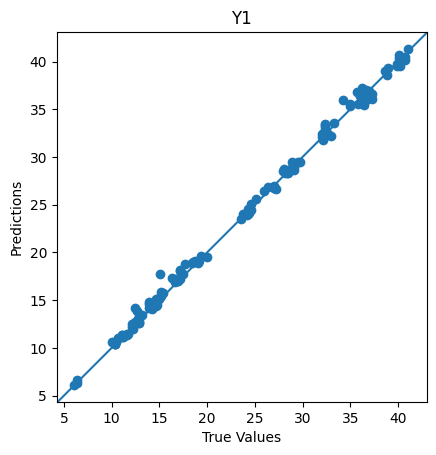

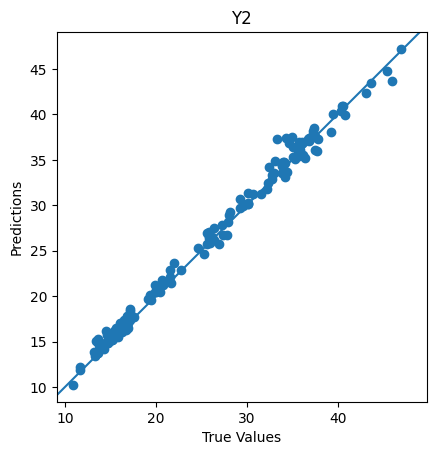

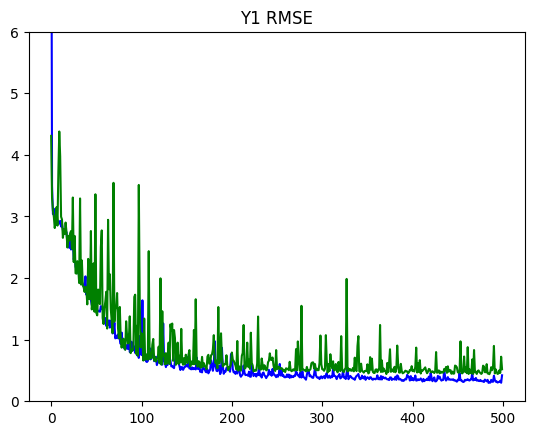

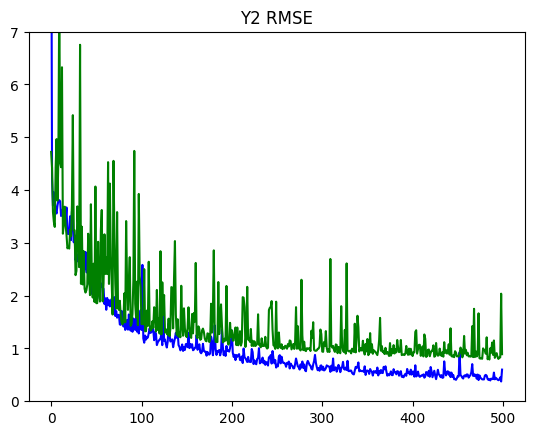

In [56]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)

In [40]:
history.history.keys()

dict_keys(['loss', 'y1_output_loss', 'y2_output_loss', 'y1_output_root_mean_squared_error', 'y2_output_root_mean_squared_error', 'val_loss', 'val_y1_output_loss', 'val_y2_output_loss', 'val_y1_output_root_mean_squared_error', 'val_y2_output_root_mean_squared_error'])

In [44]:
test_y[0], model.predict(norm_test_X)[0]

5/5 [==============================] - 0s 776us/step


(array([14.34, 11.09, 13.97, 28.05, 32.26, 14.17, 41.09, 15.18, 41.96,
        28.75, 41.67, 28.15, 15.16, 13.04, 28.37, 12.33, 14.08, 16.35,
        32.12, 40.42, 16.44, 26.84, 32.33, 32.12, 12.28, 14.6 , 36.95,
        12.71, 24.23, 39.01, 17.14, 11.22, 14.65, 13.18, 14.12, 12.34,
        28.64, 14.55, 14.92, 10.7 , 35.78, 10.75, 29.06, 12.19, 39.97,
        15.23, 14.54, 24.31, 10.07, 32.68, 14.22, 11.34, 36.64, 28.69,
        32.69, 38.98, 12.1 , 40.43, 28.07, 15.09, 18.88, 29.6 , 14.5 ,
        35.01, 23.89, 12.16, 17.69, 15.42, 24.17, 14.7 , 11.33, 36.7 ,
        11.21, 23.84, 12.93, 12.57, 36.45, 16.86, 36.91, 13.78, 12.49,
        35.48, 10.66, 32.31, 29.02, 14.42, 10.77, 31.66, 31.84, 14.34,
        32.31, 19.34, 28.6 , 11.22, 10.46, 35.24, 12.86, 29.09, 14.48,
        32.09, 32.31, 14.61, 15.16, 10.45, 18.71, 15.29, 36.06, 14.28,
        32.38, 32.96, 15.16, 10.08, 12.92,  8.5 , 28.95, 12.62, 11.69,
        26.45, 13.  , 12.74, 14.33, 32.39, 29.91, 33.27, 12.73, 12.17,
      